In [99]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

# !jt -r
# !jt -t chesterish
# !jt -t chesterish -T -N -kl
# !jt -t monokai -f office -cursw 3 -fs 11 -nfs 11 -ofs 11 -dfs 11 -cellw 95% -T -N -kl

In [2]:
import os
import itertools
import shutil

import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf

from glob import glob
from tqdm import tqdm

from matplotlib import pyplot as plt

In [94]:
class Dataset():
    def __init__(self):
        pass
    
    def read_df(self, env):
        if env == "local":
            image_paths = {os.path.basename(x): x for x in glob(os.path.join(".", "images", "*.png"))}
            df = pd.read_csv("./dataset_information/Data_Entry_2017.csv")
        elif env == "kaggle":
            image_paths = {os.path.basename(x): x for x in glob(os.path.join("..", "input", "data", "images*", "images", "*.png"))}
            df = pd.read_csv("/kaggle/input/data/Data_Entry_2017.csv")
        else:
            print("Invalid Environment. Function Returning None.")
            return None
        
        df = df.drop(
            columns = [
                "Follow-up #", "Patient ID", "Patient Age", "Patient Gender", "OriginalImage[Width", 
                "Height]", "OriginalImagePixelSpacing[x", "y]", "View Position",
            ],
            axis = 1,
        )
        
        df["Image Paths"] = " "
        for row_index in tqdm(range(len(df)), ncols = 100):
            img_name = df.iloc[row_index][0]
            path = image_paths[img_name]
            df["Image Paths"][row_index] = path
        
        return df
    
    def one_hot_encode(self, df):
        unique_labels = set(itertools.chain.from_iterable(df["Finding Labels"].apply(lambda x: x.split("|")).values))
        one_hot_labels = pd.DataFrame(0.0, index = np.arange(len(df)), columns = unique_labels)
        
        for index, row in tqdm(df.iterrows(), ncols = 100, total = 112120):
            labels = row["Finding Labels"].split("|")
            for label in labels:
                one_hot_labels.iloc[index][label] = 1.0
        df = pd.concat([df, one_hot_labels], axis = 1)
        df = df.drop(columns = ["Finding Labels"], axis = 1)
        
        return df
    
    def plot_class_samples(self, total_samples, exclusive_samples):
#         del(total_samples["No Finding"])
#         del(exclusive_samples["No Finding"])

        labels = list(total_samples.keys())
        total_count = list(total_samples.values())
        exclusive_count = [exclusive_samples[l] for l in labels]

        # Compute the difference between exclusive and total samples for each class
        differences = [exclusive_count[i] - total_count[i] for i in range(len(labels))]

        # Sort the labels and counts based on the differences
        sorted_data = sorted(zip(labels, total_count, exclusive_count, differences), key=lambda x: x[3], reverse=True)
        sorted_labels = [item[0] for item in sorted_data]
        sorted_total_count = [item[1] for item in sorted_data]
        sorted_exclusive_count = [item[2] for item in sorted_data]
        
        plt.rcParams['figure.dpi'] = 150
        fig, ax = plt.subplots(figsize=(16, 7))
        y = np.arange(len(labels))

        # Plot total samples
        ax.barh(y-0.2, sorted_total_count, height=0.3, color='teal', align='center', label='Total Samples')

        # Plot exclusive samples
        ax.barh(y+0.2, sorted_exclusive_count, height=0.4, color='darkorange', align='center', label='Exclusive Samples')

        # Add labels and legend
        ax.set_yticks(y)
        ax.set_yticklabels(sorted_labels, fontsize=14, fontweight='bold')
        ax.set_xlabel('Number of Samples', fontsize=12, fontweight='bold')
        ax.tick_params(axis='both', which='major', labelsize=15)
        ax.legend()

        # Add text annotations to bars
        for i, (total, exclusive) in enumerate(zip(sorted_total_count, sorted_exclusive_count)):
            ax.text(
                total+50, 
                i-0.1, 
                str(total), 
                color='black', 
#                 fontweight='bold', 
                fontsize=11, 
                ha='left', 
                va='center'
            )
            ax.text(
                exclusive+50, 
                i+0.3, 
                str(exclusive), 
                color='black', 
#                 fontweight='bold', 
                fontsize=11, 
                ha='left', 
                va='center'
            )

        # Add class-wise percentage
        percentages = []
        for i, (total, exclusive) in enumerate(zip(sorted_total_count, sorted_exclusive_count)):
            percentages.append(f'{sorted_labels[i]}: {exclusive / total * 100:.2f} %')
        
        percentages.insert(0, f'Total M.E. Samples: {sum(exclusive_samples.values())}\n(for 14 Diseases)\n')
        ax.text(
            0.99, 0.14, 
            '\n'.join(percentages),
            transform=ax.transAxes,
            fontsize=13,
#             fontweight='bold',
            color='black',
            ha='right',
            va='bottom'
        )

        ax.set_title('Mutually Exclusive Samples vs Total Samples', loc='center', fontweight='bold', fontsize=14)
        ax.grid(False)
        plt.show()

In [95]:
# env = "kaggle"
env = "local"

CLASS_LABELS = [
    "Atelectasis", "Cardiomegaly", "Consolidation", "Edema", "Effusion", "Emphysema", "Fibrosis", "Hernia", 
    "Infiltration", "Mass", "No Finding", "Nodule", "Pleural_Thickening", "Pneumonia","Pneumothorax"
]

In [96]:
dataset = Dataset()
df = dataset.read_df(env)
df = dataset.one_hot_encode(df)
# df.head(3)

100%|█████████████████████████████████████████████████████| 112120/112120 [00:26<00:00, 4223.74it/s]


In [97]:
total_samples_per_class = dict()
for label in CLASS_LABELS:
    total_samples_per_class[label] = int(df[label].sum())

exclusive_samples_per_class = dict()
# loop through each class column
for class_name in df.columns[2:17]:
    # filter the dataframe to include only rows where this class is present
    class_data = df[df[class_name] == 1]
    # count the number of rows where this class is present exclusively
    exclusive_count = class_data[(class_data.iloc[:,2:17] == 1).sum(axis=1) == 1].shape[0]
    # add the count to the dictionary
    exclusive_samples_per_class[class_name] = exclusive_count

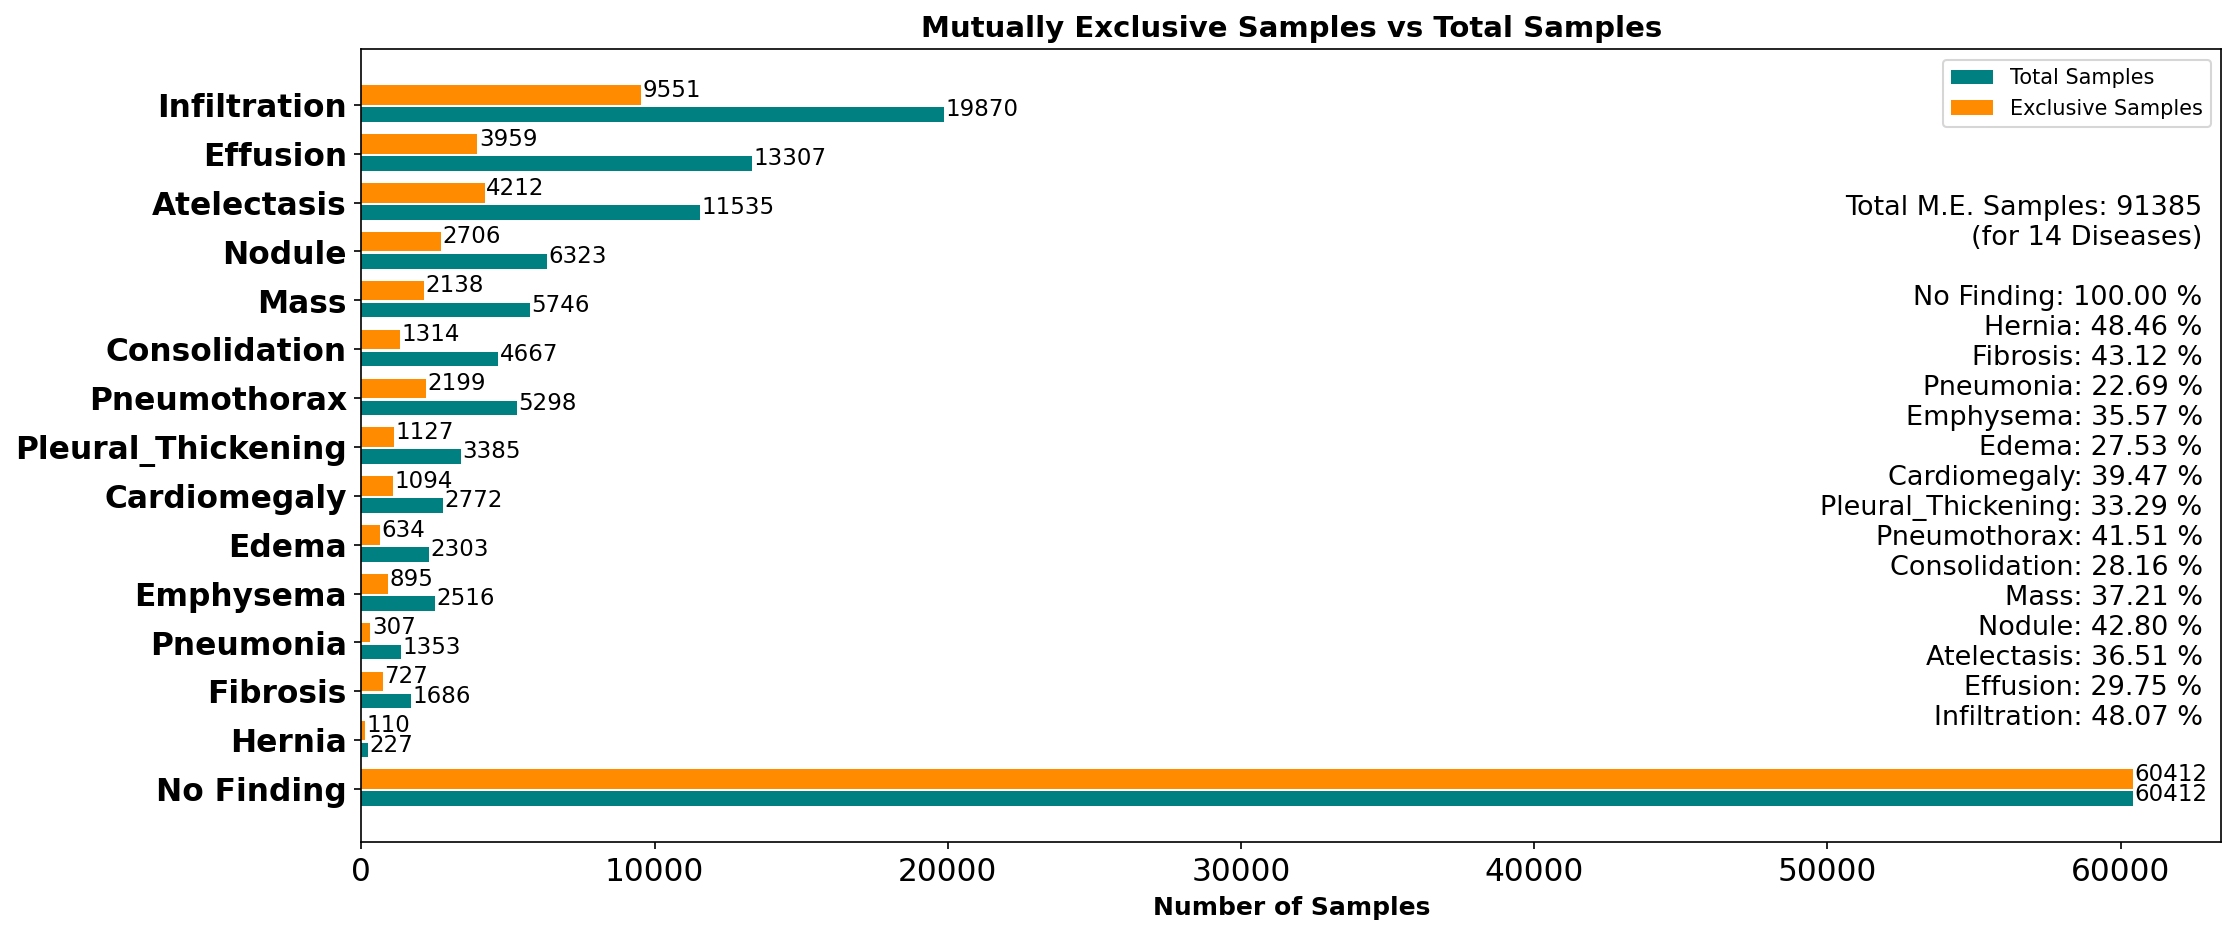

In [98]:
dataset.plot_class_samples(total_samples_per_class, exclusive_samples_per_class)

In [8]:
# This dict will store diseased class labels as keys and a dictionary of images' paths and samples count, as its values
# e.g. dict['Hernia'] = {count: 110, images = ['./images/img1.png', './images/img2.png', ... ]}
mutual_excl_images_per_class = {}

for class_name in df.columns[2:17]: # loop through each class column
    
    class_data = df[df[class_name] == 1] # filter the dataframe to include only rows where this class is present
    exclusive_count = class_data[(class_data.iloc[:,2:17] == 1).sum(axis=1) == 1].shape[0] # count the number of rows where this class is present exclusively
    exclusive_image_names = class_data[(class_data.iloc[:,2:17] == 1).sum(axis=1) == 1].iloc[:,1] # get the image names for the rows where this class is present exclusively
    
    mutual_excl_images_per_class[class_name] = {'count': exclusive_count, 'images': exclusive_image_names.tolist()} # add the count and image names to the dictionary

In [43]:
def copy_images(file_list, dest_folder, flag = False):
    if not os.path.exists(dest_folder): # Create destination folder if it doesn't exist
        os.makedirs(dest_folder)
    
    new_paths = []
    for file_path in file_list:
        file_name = os.path.basename(file_path) # Get the file name and extension
        new_paths.append(os.path.join(dest_folder, file_name)) # Appedning the new path of images relative to the class label
        
        if flag:
            shutil.copy2(file_path, os.path.join(dest_folder, file_name)) # Copy the file to the destination folder
    
    return new_paths

In [44]:
new_images_paths = dict()
for label, value in mutual_excl_images_per_class.items():
    print(f"Copying images belonging to class: {label}")
    
    if label == "No Finding": # Skipping copying of images belonging to No Finding class.
        continue

    path = ".\\Mutually_Exclusive_Images\\" + label
    new_images_paths[label] = copy_images(mutual_excl_images_per_class[label]["images"], path)

Copying images belonging to class: Consolidation
Copying images belonging to class: Nodule
Copying images belonging to class: Effusion
Copying images belonging to class: Infiltration
Copying images belonging to class: Hernia
Copying images belonging to class: Cardiomegaly
Copying images belonging to class: Atelectasis
Copying images belonging to class: Pneumothorax
Copying images belonging to class: Pleural_Thickening
Copying images belonging to class: Edema
Copying images belonging to class: Fibrosis
Copying images belonging to class: Pneumonia
Copying images belonging to class: Emphysema
Copying images belonging to class: Mass


In [10]:
class Generator():
    pass

In [11]:
class Discriminator():
    pass